# Process plate counts to get ratios of variants and determine pooling and MOI
This notebook is designed to be run using `snakemake`, and analyzes a plate of sequencing-based neutralization assays.

The plots generated by this notebook are interactive, so you can mouseover points for details, use the mouse-scroll to zoom and pan, and use interactive dropdowns at the bottom of the plots.

## Setup
Import Python modules:

In [66]:
import pickle
import sys

import altair as alt

import matplotlib.pyplot as plt

import numpy

import pandas as pd
from os.path import join
import os
import ruamel.yaml as yaml
import numpy as np

_ = alt.data_transformers.disable_max_rows()

Get the variables passed by `snakemake`:

In [2]:
#count_csvs = snakemake.input.count_csvs
#fate_csvs = snakemake.input.fate_csvs
#viral_library_csv = snakemake.input.viral_library_csv
#neut_standard_set_csv = snakemake.input.neut_standard_set_csv
#samples = snakemake.params.samples
#plate = "Titer_plate"

In [5]:
viral_library_csv = "../data/viral_libraries/H1N1_2023_library.csv"
neut_standard_set_csv = "../data/neut_standard_sets/loes2023_neut_standards.csv"
filepath_prefix = "../"
barcode_runs_df = pd.read_csv("../data/plates/plate4_MOItests_6and8hr.csv")
barcode_runs_df.drop(columns=["fastq"], inplace=True)
barcode_runs_df["sample"] = barcode_runs_df.apply(
    lambda x: "-".join(x.astype(str)), axis=1
)

samples = barcode_runs_df["well"].unique().tolist()
print(f"There are {len(samples)} barcode runs.")

file_list = os.listdir(r'../results/miscellaneous_plates/plate4_MOItests')
count_csvs = []
for f in file_list:
    location = '../results/miscellaneous_plates/plate4_MOItests/' + f
    if "_counts" in f:
        count_csvs.append(location)

# file_list_withdir
fate_csvs = []
file_list = os.listdir(r'../results/miscellaneous_plates/plate4_MOItests/')
for f in file_list:
    location = '../results/miscellaneous_plates/plate4_MOItests/' + f
    if "_fates" in f:
        fate_csvs.append(location)

samples_df = barcode_runs_df
samples_df

There are 56 barcode runs.


,well,serum,dilution_factor,replicate,sample
0,B1,MOI_100K_rep1_6h,2,1,B1-MOI_100K_rep1_6h-2-1
1,C1,MOI_100K_rep1_6h,4,1,C1-MOI_100K_rep1_6h-4-1
2,D1,MOI_100K_rep1_6h,8,1,D1-MOI_100K_rep1_6h-8-1
3,E1,MOI_100K_rep1_6h,16,1,E1-MOI_100K_rep1_6h-16-1
4,F1,MOI_100K_rep1_6h,32,1,F1-MOI_100K_rep1_6h-32-1
5,G1,MOI_100K_rep1_6h,64,1,G1-MOI_100K_rep1_6h-64-1
6,H1,MOI_100K_rep1_6h,128,1,H1-MOI_100K_rep1_6h-128-1
7,B2,MOI_100K_rep2_6h,2,2,B2-MOI_100K_rep2_6h-2-2
8,C2,MOI_100K_rep2_6h,4,2,C2-MOI_100K_rep2_6h-4-2
9,D2,MOI_100K_rep2_6h,8,2,D2-MOI_100K_rep2_6h-8-2


## Statistics on barcode-parsing for each sample
Make interactive chart of the "fates" of the sequencing reads parsed for each sample on the plate.

If most sequencing reads are not "valid barcodes", this could potentially indicate some problem in the sequencing or barcode set you are parsing.

Potential fates are:
 - *valid barcode*: barcode that matches a known virus or neutralization standard, we hope most reads are this.
 - *invalid barcode*: a barcode with proper flanking sequences, but does not match a known virus or neutralization standard. If you  have a lot of reads of this type, it is probably a good idea to look at the invalid barcode CSVs (in the `./results/barcode_invalid/` subdirectory created by the pipeline) to see what these invalid barcodes are.
 - *unparseable barcode*: could not parse a barcode from this read as there was not a sequence of the correct length with the appropriate flanking sequence.
 - *low quality barcode*: low-quality or `N` nucleotides in barcode, could indicate problem with sequencing.
 - *failed chastity filter*: reads that failed the Illumina chastity filter, if these are reported in the FASTQ (they may not be).

Also, if the number of reads per sample is very uneven, that could indicate that you did not do a good job of balancing the different samples in the Illumina sequencing.

In [6]:
fates = (
    pd.concat([pd.read_csv(f).assign(well=f.strip("../results/miscellaneous_plates/plate4_MOItests/").strip('_fates.csv')) for f, s in zip(fate_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="well")
    .assign(
        fate_counts=lambda x: x.groupby("fate")["count"].transform("sum"),
        sample_well=lambda x: x["serum"] + " (" + x["well"] + ")",
    )
    .query("fate_counts > 0")[  # only keep fates with at least one count
        ["fate", "count", "well", "sample_well", "dilution_factor"]
    ]
)
fates
assert len(fates) == len(fates.drop_duplicates())


sample_wells = list(fates.sort_values(["dilution_factor"])["sample_well"])


fates_chart = (
    alt.Chart(fates)
    .encode(
        alt.X("count", scale=alt.Scale(nice=False, padding=3)),
        alt.Y(
            "sample_well",
            title=None,
            sort=sample_wells,
        ),
        alt.Color("fate", sort=sorted(fates["fate"].unique(), reverse=True)),
        alt.Order("fate", sort="descending"),
        tooltip=fates.columns.tolist(),
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=200,
        title=f"Barcode parsing for initial titering plate",
    )
    .configure_axis(grid=False)
)

fates_chart
#fates

alt.Chart(...)

## Read barcode counts
Read the counts per barcode:

In [7]:
# get barcode counts
counts = (
    pd.concat([pd.read_csv(c).assign(well=c.strip("../results/miscellaneous_plates/plate4_MOItests/").strip('_counts.csv')) for c, s in zip(count_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="well")
    .drop(columns=["replicate"])
    .assign(sample_well=lambda x: x["sample"] + " (" + x["well"] + ")")
)

# classify barcodes as viral or neut standard
barcode_class = pd.concat(
    [
        pd.read_csv(viral_library_csv)[["barcode", "strain"]].assign(
            neut_standard=False,
        ),
        pd.read_csv(neut_standard_set_csv)[["barcode"]].assign(
            neut_standard=True,
            strain=pd.NA,
        ),
    ],
    ignore_index=True,
)

# merge counts and classification of barcodes
assert set(counts["barcode"]) == set(barcode_class["barcode"])
counts = counts.merge(barcode_class, on="barcode", validate="many_to_one")
#assert set(sample_wells) == set(counts["sample_well"])

Apply any manually specified data drops:

## Average counts per barcode in each well

Plot average counts per barcode.
If a sample has inadequate barcode counts, it may not have good enough statistics for accurate analysis, and a QC-threshold is applied:

In [8]:
avg_barcode_counts = (
    counts.groupby(
        ["well", "sample_well"],
        dropna=False,
        as_index=False,
    )
    .aggregate(avg_count=pd.NamedAgg("count", "mean"))
    .assign(
        fails_qc=lambda x: (
            x["avg_count"] < 500
        ),
    )
)

avg_barcode_counts_chart = (
    alt.Chart(avg_barcode_counts)
    .encode(
        alt.X(
            "avg_count",
            title="average barcode counts per well",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("sample_well", sort=sample_wells),
        alt.Color(
            "fails_qc",
            title=f"fails {'min barcode count threshold'=}",
            legend=alt.Legend(titleLimit=500),
        ),
        tooltip=[
            alt.Tooltip(c, format=".3g") if avg_barcode_counts[c].dtype == float else c
            for c in avg_barcode_counts.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Average barcode counts per well for titering plate",
    )
    .configure_axis(grid=False)
)

display(avg_barcode_counts_chart)

# drop wells failing QC
avg_barcode_counts_per_well_drops = list(avg_barcode_counts.query("fails_qc")["well"])

alt.Chart(...)

## Fraction of counts from neutralization standard
Determine the fraction of counts from the neutralization standard in each sample, and make sure this fraction passess the QC threshold.

In [9]:
neut_standard_fracs = (
    counts.assign(
        neut_standard_count=lambda x: x["count"] * x["neut_standard"].astype(int)
    )
    .groupby(
        ["well", "sample_well"],
        dropna=False,
        as_index=False,
    )
    .aggregate(
        total_count=pd.NamedAgg("count", "sum"),
        neut_standard_count=pd.NamedAgg("neut_standard_count", "sum"),
    )
    .assign(
        neut_standard_frac=lambda x: x["neut_standard_count"] / x["total_count"],
        fails_qc=lambda x: (
            x["neut_standard_frac"] < 0.001
        ),
    )
)

neut_standard_fracs_chart = (
    alt.Chart(neut_standard_fracs)
    .encode(
        alt.X(
            "neut_standard_frac",
            title="frac counts from neutralization standard per well",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("sample_well", sort=sample_wells),
        alt.Color(
            "fails_qc",
            title=f"fails {'min_neut_standard_frac_per_well'=}",
            legend=alt.Legend(titleLimit=500),
        ),
        tooltip=[
            alt.Tooltip(c, format=".3g") if neut_standard_fracs[c].dtype == float else c
            for c in neut_standard_fracs.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Neutralization-standard fracs per well for titering plate",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
)

display(neut_standard_fracs_chart)


alt.Chart(...)

,well,sample_well,total_count,neut_standard_count,neut_standard_frac,fails_qc,dilution,set,cells,time,colors,colors2,norm
0,B1,B1-MOI_100K_rep1_6h-2-1 (B1),1492636,7681,0.005146,False,2,100K_6h,100K,6h,firebrick,goldenrod,0.002573
1,B10,B10-MOI_200K_rep1_8h-2-1 (B10),1042753,5532,0.005305,False,2,200K_8h,200K,8h,rebeccapurple,steelblue,0.002653
2,B11,B11-MOI_200K_rep2_8h-2-2 (B11),489536,2694,0.005503,False,2,200K_8h,200K,8h,rebeccapurple,steelblue,0.002752
3,B2,B2-MOI_100K_rep2_6h-2-2 (B2),1122950,5833,0.005194,False,2,100K_6h,100K,6h,firebrick,goldenrod,0.002597
4,B4,B4-MOI_200K_rep1_6h-2-1 (B4),1230160,6719,0.005462,False,2,200K_6h,200K,6h,firebrick,steelblue,0.002731
5,B5,B5-MOI_200K_rep2_6h-2-2 (B5),1418934,8969,0.006321,False,2,200K_6h,200K,6h,firebrick,steelblue,0.003160
6,B7,B7-MOI_100K_rep1_8h-2-1 (B7),882817,3947,0.004471,False,2,100K_8h,100K,8h,rebeccapurple,goldenrod,0.002235
7,B8,B8-MOI_100K_rep2_8h-2-2 (B8),875337,3953,0.004516,False,2,100K_8h,100K,8h,rebeccapurple,goldenrod,0.002258
8,C1,C1-MOI_100K_rep1_6h-4-1 (C1),1170422,8532,0.007290,False,4,100K_6h,100K,6h,firebrick,goldenrod,0.001822
9,C10,C10-MOI_200K_rep1_8h-4-1 (C10),1364406,9329,0.006837,False,4,200K_8h,200K,8h,rebeccapurple,steelblue,0.001709


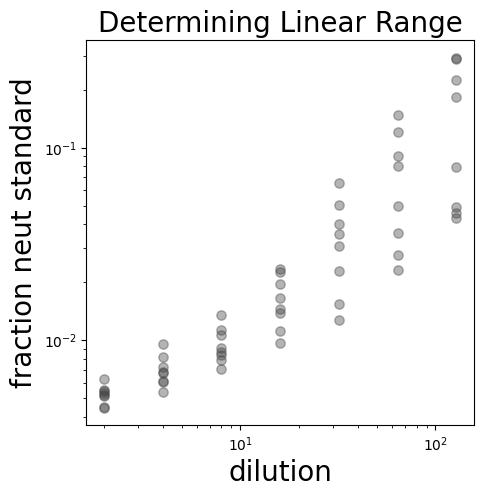

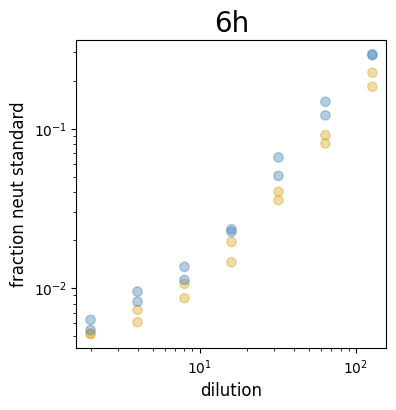

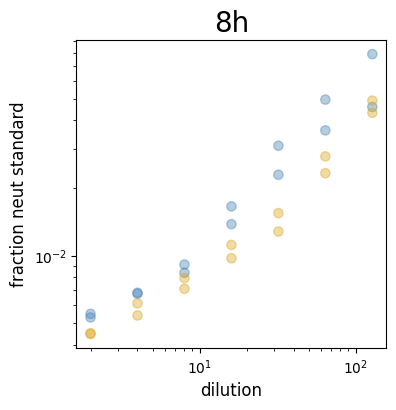

In [10]:
neut_standard_fracs['dilution'] = neut_standard_fracs['sample_well'].str.split('-').str[2].astype(int)
ax1 = neut_standard_fracs.plot.scatter(x='dilution',y='neut_standard_frac',c='#444444',s=45, xlabel='dilution', ylabel="neut_standard_frac", fontsize=10,figsize=(5,5), alpha=0.4, loglog=True)
ax1.set_ylabel('fraction neut standard',fontdict={'fontsize':20})
ax1.set_xlabel('dilution',fontdict={'fontsize':20})
ax1.set_title('Determining Linear Range',fontdict={'fontsize':20})
neut_standard_fracs['set'] = neut_standard_fracs['sample_well'].str.split('-').str[1]
neut_standard_fracs['cells'] = neut_standard_fracs['set'].str.split('_').str[1]
neut_standard_fracs['time'] = neut_standard_fracs['set'].str.split('_').str[3]
neut_standard_fracs['set'] = neut_standard_fracs['cells'] +"_" + neut_standard_fracs['time']
neut_standard_fracs['colors'] = neut_standard_fracs['time']
neut_standard_fracs['colors'] = neut_standard_fracs['colors'].replace("6h","firebrick")
neut_standard_fracs['colors'] = neut_standard_fracs['colors'].replace("8h","rebeccapurple")
neut_standard_fracs['colors2'] = neut_standard_fracs['cells']
neut_standard_fracs['colors2'] = neut_standard_fracs['colors2'].replace("100K","goldenrod")
neut_standard_fracs['colors2'] = neut_standard_fracs['colors2'].replace("200K","steelblue")
neut_standard_fracs['norm'] = neut_standard_fracs['neut_standard_frac']/neut_standard_fracs['dilution']
samples = neut_standard_fracs['time'].unique().tolist()
neut_standard_fracs
for i in samples:
    ax1 = neut_standard_fracs.loc[neut_standard_fracs['time'] == i].plot.scatter(x='dilution',y='neut_standard_frac',c='colors2',s=45, xlabel='dilution', ylabel="neut_standard_frac", fontsize=10,figsize=(4,4), alpha=0.4, loglog=True)
    ax1.set_ylabel('fraction neut standard',fontdict={'fontsize':12})
    ax1.set_xlabel('dilution',fontdict={'fontsize':12})
    ax1.set_title(i,fontdict={'fontsize':20})


neut_standard_fracs

## Testing spike in of new viruses

In [24]:
viral_library_csv = "../data/viral_libraries/H1N1_2023_library.csv"
neut_standard_set_csv = "../data/neut_standard_sets/loes2023_neut_standards.csv"
filepath_prefix = "../"
barcode_runs_df = pd.read_csv("../data/plates/plate4_testrescues.csv")
barcode_runs_df.drop(columns=["fastq"], inplace=True)
barcode_runs_df["sample"] = barcode_runs_df.apply(
    lambda x: "-".join(x.astype(str)), axis=1
)

samples = barcode_runs_df["well"].unique().tolist()
print(f"There are {len(samples)} barcode runs.")

file_list = os.listdir(r'../results/miscellaneous_plates/plate4_testrescues')
count_csvs = []
for f in file_list:
    location = '../results/miscellaneous_plates/plate4_testrescues/' + f
    if "_counts" in f:
        count_csvs.append(location)

# file_list_withdir
fate_csvs = []
file_list = os.listdir(r'../results/miscellaneous_plates/plate4_testrescues/')
for f in file_list:
    location = '../results/miscellaneous_plates/plate4_testrescues/' + f
    if "_fates" in f:
        fate_csvs.append(location)

samples_df = barcode_runs_df
samples_df

There are 4 barcode runs.


,well,serum,dilution_factor,replicate,sample
0,A3,MI23_1,1,1,A3-MI23_1-1-1
1,B3,MI23_2,1,1,B3-MI23_2-1-1
2,C3,MI23_3,1,1,C3-MI23_3-1-1
3,D3,VI22_1,1,1,D3-VI22_1-1-1


In [25]:
fates = (
    pd.concat([pd.read_csv(f).assign(well=f.strip("../results/miscellaneous_plates/plate4_testrescues/").strip('_fates.csv')) for f, s in zip(fate_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="well")
    .assign(
        fate_counts=lambda x: x.groupby("fate")["count"].transform("sum"),
        sample_well=lambda x: x["serum"] + " (" + x["well"] + ")",
    )
    .query("fate_counts > 0")[  # only keep fates with at least one count
        ["fate", "count", "well", "sample_well", "dilution_factor"]
    ]
)
fates
assert len(fates) == len(fates.drop_duplicates())


sample_wells = list(fates.sort_values(["dilution_factor"])["sample_well"])


fates_chart = (
    alt.Chart(fates)
    .encode(
        alt.X("count", scale=alt.Scale(nice=False, padding=3)),
        alt.Y(
            "sample_well",
            title=None,
            sort=sample_wells,
        ),
        alt.Color("fate", sort=sorted(fates["fate"].unique(), reverse=True)),
        alt.Order("fate", sort="descending"),
        tooltip=fates.columns.tolist(),
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=200,
        title=f"Barcode parsing for initial titering plate",
    )
    .configure_axis(grid=False)
)

fates_chart
#fates

alt.Chart(...)

In [26]:
# get barcode counts
counts = (
    pd.concat([pd.read_csv(c).assign(well=c.strip("../results/miscellaneous_plates/plate4_testrescues/").strip('_counts.csv')) for c, s in zip(count_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="well")
    .drop(columns=["replicate"])
    .assign(sample_well=lambda x: x["sample"] + " (" + x["well"] + ")")
)

# classify barcodes as viral or neut standard
barcode_class = pd.concat(
    [
        pd.read_csv(viral_library_csv)[["barcode", "strain"]].assign(
            neut_standard=False,
        ),
        pd.read_csv(neut_standard_set_csv)[["barcode"]].assign(
            neut_standard=True,
            strain=pd.NA,
        ),
    ],
    ignore_index=True,
)

# merge counts and classification of barcodes
assert set(counts["barcode"]) == set(barcode_class["barcode"])
counts = counts.merge(barcode_class, on="barcode", validate="many_to_one")
counts

,barcode,count,well,serum,dilution_factor,sample,sample_well,strain,neut_standard
0,CAAGGAAACCGGTTGA,10798,B3,MI23_2,1,B3-MI23_2-1-1,B3-MI23_2-1-1 (B3),A/Oregon/Flu-OHSU-241140095/2023,False
1,AGCAGTAAATAAAATC,6108,B3,MI23_2,1,B3-MI23_2-1-1,B3-MI23_2-1-1 (B3),A/Oregon/Flu-OHSU-241140095/2023,False
2,AAAATCATTCGACTCT,2775,B3,MI23_2,1,B3-MI23_2-1-1,B3-MI23_2-1-1 (B3),A/Oregon/Flu-OHSU-241140095/2023,False
3,CTTTAAATTATAGTCT,1,B3,MI23_2,1,B3-MI23_2-1-1,B3-MI23_2-1-1 (B3),NaN,True
4,AAAAAATTTATGACAA,0,B3,MI23_2,1,B3-MI23_2-1-1,B3-MI23_2-1-1 (B3),NaN,True
...,...,...,...,...,...,...,...,...,...
819,TTGAAAGCCACAACAC,0,C3,MI23_3,1,C3-MI23_3-1-1,C3-MI23_3-1-1 (C3),A/Pennsylvania/51/2023,False
820,TTGGGCACTAAATTAA,0,C3,MI23_3,1,C3-MI23_3-1-1,C3-MI23_3-1-1 (C3),A/Brisbane/02/2018,False
821,TTGGGGATTGCCCAAA,0,C3,MI23_3,1,C3-MI23_3-1-1,C3-MI23_3-1-1 (C3),A/Washington/32/2023,False
822,TTTGCTCGCAAAACCA,0,C3,MI23_3,1,C3-MI23_3-1-1,C3-MI23_3-1-1 (C3),A/Norway/8030/2023,False


In [27]:
counts_balancedbarcode = counts.groupby(['sample','strain','dilution_factor','serum','well','barcode']).sum()
counts_balancedbarcode = counts_balancedbarcode.reset_index().drop(columns = ['neut_standard'])

In [28]:
#First calculate the total counts per barcode in each well
sumperwell = counts_balancedbarcode.groupby(['sample','sample_well','dilution_factor','serum','well']).sum().drop(columns=['strain','barcode'])
sumperwell = sumperwell.reset_index()
sumperwell

,sample,sample_well,dilution_factor,serum,well,count
0,A3-MI23_1-1-1,A3-MI23_1-1-1 (A3),1,MI23_1,A3,16813
1,B3-MI23_2-1-1,B3-MI23_2-1-1 (B3),1,MI23_2,B3,19681
2,C3-MI23_3-1-1,C3-MI23_3-1-1 (C3),1,MI23_3,C3,24165
3,D3-VI22_1-1-1,D3-VI22_1-1-1 (D3),1,VI22_1,D3,21628


In [29]:
#Then calculate the sum of barcodes corresponding to barcoded variants per well and calculate the fraction of counts that each barcode represents of barcode counts per well
sumperwell = sumperwell.rename(columns={'count':'counts_perwell'})
counts_balancedbarcode = counts_balancedbarcode.merge(sumperwell, on=['sample','sample_well','dilution_factor','serum','well'])
counts_balancedbarcode['fraction_barcode'] = counts_balancedbarcode['count'] /counts_balancedbarcode['counts_perwell'] 
counts_balancedbarcode = counts_balancedbarcode.loc[counts_balancedbarcode['count'] > 1]

In [30]:
counts_balancedbarcode

,sample,strain,dilution_factor,serum,well,barcode,count,sample_well,counts_perwell,fraction_barcode
95,A3-MI23_1-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_1,A3,AAAATCATTCGACTCT,2470,A3-MI23_1-1-1 (A3),16813,0.146910
96,A3-MI23_1-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_1,A3,AGCAGTAAATAAAATC,5279,A3-MI23_1-1-1 (A3),16813,0.313983
97,A3-MI23_1-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_1,A3,CAAGGAAACCGGTTGA,9064,A3-MI23_1-1-1 (A3),16813,0.539107
292,B3-MI23_2-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_2,B3,AAAATCATTCGACTCT,2775,B3-MI23_2-1-1 (B3),19681,0.140999
293,B3-MI23_2-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_2,B3,AGCAGTAAATAAAATC,6108,B3-MI23_2-1-1 (B3),19681,0.310350
294,B3-MI23_2-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_2,B3,CAAGGAAACCGGTTGA,10798,B3-MI23_2-1-1 (B3),19681,0.548651
489,C3-MI23_3-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_3,C3,AAAATCATTCGACTCT,3563,C3-MI23_3-1-1 (C3),24165,0.147445
490,C3-MI23_3-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_3,C3,AGCAGTAAATAAAATC,7234,C3-MI23_3-1-1 (C3),24165,0.299359
491,C3-MI23_3-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_3,C3,CAAGGAAACCGGTTGA,13365,C3-MI23_3-1-1 (C3),24165,0.553073
776,D3-VI22_1-1-1,A/Victoria/4897/2022_IVR238,1,VI22_1,D3,AAGTTAAGAGAAAGTT,15783,D3-VI22_1-1-1 (D3),21628,0.729748


In [31]:
#Now we select a couple wells where we think the vRNA counts should correspond to linearly to titers based on prior experiments amd calculate the sum of all barcodes for each strain and determine the fraction of counts that is each strain
subset_of_wells = counts_balancedbarcode.loc[counts_balancedbarcode['sample'].str.contains('A3|B3|C3|D3')] #Take wells where fraction neut-standard is reasonable
sum_barcodes_bystrain = subset_of_wells.groupby(['strain','well'])['fraction_barcode'].sum().to_frame().rename(columns = {'fraction_barcode': 'fraction_strain_perwell'}).reset_index()

In [32]:
mean_df = sum_barcodes_bystrain.groupby(['strain'])['fraction_strain_perwell'].mean().to_frame().rename(columns = {'fraction_strain_perwell': 'mean_fraction_strains_subsetwells'}).reset_index()
mean_df = sum_barcodes_bystrain.merge(mean_df, on = 'strain', how = 'left')

In [33]:
mean_single_well = subset_of_wells.merge(mean_df, on = ['strain','well'], how = 'left')

# calcualte ratios to add
num_strains = 64
mean_single_well['ratio_to_add'] = (1/num_strains)/mean_single_well['fraction_strain_perwell']
mean_single_well['mean_ratio_to_add'] = (1/num_strains)/mean_single_well['mean_fraction_strains_subsetwells']

mean_single_well['est_tcid50'] = (mean_single_well['mean_fraction_strains_subsetwells']*17433)*64

mean_single_well

,sample,strain,dilution_factor,serum,well,barcode,count,sample_well,counts_perwell,fraction_barcode,fraction_strain_perwell,mean_fraction_strains_subsetwells,ratio_to_add,mean_ratio_to_add,est_tcid50
0,A3-MI23_1-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_1,A3,AAAATCATTCGACTCT,2470,A3-MI23_1-1-1 (A3),16813,0.146910,1.000000,0.999959,0.015625,0.015626,1.115666e+06
1,A3-MI23_1-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_1,A3,AGCAGTAAATAAAATC,5279,A3-MI23_1-1-1 (A3),16813,0.313983,1.000000,0.999959,0.015625,0.015626,1.115666e+06
2,A3-MI23_1-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_1,A3,CAAGGAAACCGGTTGA,9064,A3-MI23_1-1-1 (A3),16813,0.539107,1.000000,0.999959,0.015625,0.015626,1.115666e+06
3,B3-MI23_2-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_2,B3,AAAATCATTCGACTCT,2775,B3-MI23_2-1-1 (B3),19681,0.140999,1.000000,0.999959,0.015625,0.015626,1.115666e+06
4,B3-MI23_2-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_2,B3,AGCAGTAAATAAAATC,6108,B3-MI23_2-1-1 (B3),19681,0.310350,1.000000,0.999959,0.015625,0.015626,1.115666e+06
5,B3-MI23_2-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_2,B3,CAAGGAAACCGGTTGA,10798,B3-MI23_2-1-1 (B3),19681,0.548651,1.000000,0.999959,0.015625,0.015626,1.115666e+06
6,C3-MI23_3-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_3,C3,AAAATCATTCGACTCT,3563,C3-MI23_3-1-1 (C3),24165,0.147445,0.999876,0.999959,0.015627,0.015626,1.115666e+06
7,C3-MI23_3-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_3,C3,AGCAGTAAATAAAATC,7234,C3-MI23_3-1-1 (C3),24165,0.299359,0.999876,0.999959,0.015627,0.015626,1.115666e+06
8,C3-MI23_3-1-1,A/Oregon/Flu-OHSU-241140095/2023,1,MI23_3,C3,CAAGGAAACCGGTTGA,13365,C3-MI23_3-1-1 (C3),24165,0.553073,0.999876,0.999959,0.015627,0.015626,1.115666e+06
9,D3-VI22_1-1-1,A/Victoria/4897/2022_IVR238,1,VI22_1,D3,AAGTTAAGAGAAAGTT,15783,D3-VI22_1-1-1 (D3),21628,0.729748,0.999954,0.999954,0.015626,0.015626,1.115660e+06


In [34]:
assess_barcodebalancing = mean_single_well.loc[mean_single_well['well'].str.contains('A3|B3|C3|D3')][['strain','barcode','fraction_barcode','count','counts_perwell','well']]
assess_barcodebalancing_bystrain = assess_barcodebalancing.groupby(['strain'])['count'].sum().to_frame().rename(columns = {'count': 'count_perstrain_perwell'}).reset_index()
assess_barcodebalancing_bystrain
assess_barcodebalancing = assess_barcodebalancing.merge(assess_barcodebalancing_bystrain, on="strain")
assess_barcodebalancing['fraction_of_strain_barcode'] = assess_barcodebalancing['count']/assess_barcodebalancing['count_perstrain_perwell']
assess_barcodebalancing

,strain,barcode,fraction_barcode,count,counts_perwell,well,count_perstrain_perwell,fraction_of_strain_barcode
0,A/Oregon/Flu-OHSU-241140095/2023,AAAATCATTCGACTCT,0.146910,2470,16813,A3,60656,0.040721
1,A/Oregon/Flu-OHSU-241140095/2023,AGCAGTAAATAAAATC,0.313983,5279,16813,A3,60656,0.087032
2,A/Oregon/Flu-OHSU-241140095/2023,CAAGGAAACCGGTTGA,0.539107,9064,16813,A3,60656,0.149433
3,A/Oregon/Flu-OHSU-241140095/2023,AAAATCATTCGACTCT,0.140999,2775,19681,B3,60656,0.045750
4,A/Oregon/Flu-OHSU-241140095/2023,AGCAGTAAATAAAATC,0.310350,6108,19681,B3,60656,0.100699
5,A/Oregon/Flu-OHSU-241140095/2023,CAAGGAAACCGGTTGA,0.548651,10798,19681,B3,60656,0.178020
6,A/Oregon/Flu-OHSU-241140095/2023,AAAATCATTCGACTCT,0.147445,3563,24165,C3,60656,0.058741
7,A/Oregon/Flu-OHSU-241140095/2023,AGCAGTAAATAAAATC,0.299359,7234,24165,C3,60656,0.119263
8,A/Oregon/Flu-OHSU-241140095/2023,CAAGGAAACCGGTTGA,0.553073,13365,24165,C3,60656,0.220341
9,A/Victoria/4897/2022_IVR238,AAGTTAAGAGAAAGTT,0.729748,15783,21628,D3,21627,0.729782


In [35]:
barcode_balance_chart = (
    alt.Chart(assess_barcodebalancing)
    .encode(
        alt.X("fraction_barcode", scale=alt.Scale(nice=False, padding=3)),
        alt.Y(
            "well",
            title=None,
            sort=sample_wells,
        ),
        alt.Color("barcode", sort=sorted(assess_barcodebalancing["strain"].unique())).scale(range = ['steelblue', 'goldenrod','firebrick']),
    )
    .mark_bar(height={"band": 0.75})
    .properties(
        height=alt.Step(36),
        width=450,
    )
    .configure_axis(grid=False,labelFontSize=18,titleFontSize=18,labelLimit=300)
)

barcode_balance_chart

alt.Chart(...)

In [36]:
## Testing volume of new viruses that we should add

In [37]:
barcode_runs_df = pd.read_csv("../data/plates/plate4_5J8_16hr.csv")
barcode_runs_df.drop(columns=["fastq"], inplace=True)
barcode_runs_df["sample"] = barcode_runs_df.apply(
    lambda x: "-".join(x.astype(str)), axis=1
)

samples = barcode_runs_df["well"].unique().tolist()
print(f"There are {len(samples)} barcode runs.")

file_list = os.listdir(r'../results/miscellaneous_plates/plate4_5J8_16hr')
count_csvs = []
for f in file_list:
    location = '../results/miscellaneous_plates/plate4_5J8_16hr/' + f
    if "_counts" in f:
        count_csvs.append(location)

# file_list_withdir
fate_csvs = []
file_list = os.listdir(r'../results/miscellaneous_plates/plate4_5J8_16hr/')
for f in file_list:
    location = '../results/miscellaneous_plates/plate4_5J8_16hr/' + f
    if "_fates" in f:
        fate_csvs.append(location)

samples_df = barcode_runs_df
samples_df

There are 16 barcode runs.


,well,serum,dilution_factor,replicate,sample
0,A1,none,1,1,A1-none-1-1
1,B1,none,1,2,B1-none-1-2
2,C1,none,1,3,C1-none-1-3
3,D1,none,1,4,D1-none-1-4
4,E1,none,1,5,E1-none-1-5
5,F1,none,1,6,F1-none-1-6
6,G1,none,1,7,G1-none-1-7
7,H1,none,1,8,H1-none-1-8
8,A2,5J8_newviruses,1,1,A2-5J8_newviruses-1-1
9,B2,5J8_newviruses,2,1,B2-5J8_newviruses-2-1


In [38]:
samples_df['sample'] = 'plate4_5J8_none-' + samples_df['replicate'].astype(str) + "_1"
samples_df = samples_df.loc[samples_df['serum'].str.contains('none')]
samples_df

,well,serum,dilution_factor,replicate,sample
0,A1,none,1,1,plate4_5J8_none-1_1
1,B1,none,1,2,plate4_5J8_none-2_1
2,C1,none,1,3,plate4_5J8_none-3_1
3,D1,none,1,4,plate4_5J8_none-4_1
4,E1,none,1,5,plate4_5J8_none-5_1
5,F1,none,1,6,plate4_5J8_none-6_1
6,G1,none,1,7,plate4_5J8_none-7_1
7,H1,none,1,8,plate4_5J8_none-8_1


In [39]:
count_csvs

['../results/miscellaneous_plates/plate4_5J8_16hr/H2_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/D1_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/B2_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/E1_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/B1_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/C1_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/C2_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/F2_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/A1_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/F1_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/E2_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/G1_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/G2_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/H1_counts.csv',
 '../results/miscellaneous_plates/plate4_5J8_16hr/D2_counts.csv',
 '../resul

In [40]:
# get barcode counts
counts = (
    pd.concat([pd.read_csv(c).assign(well=c.strip("../results/miscellaneous_plates/plate4_5J8_16hr/").strip('_counts.csv')) for c, s in zip(count_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="well")
    .drop(columns=["replicate"])
    .assign(sample_well=lambda x: x["sample"] + " (" + x["well"] + ")")
)

# classify barcodes as viral or neut standard
barcode_class = pd.concat(
    [
        pd.read_csv(viral_library_csv)[["barcode", "strain"]].assign(
            neut_standard=False,
        ),
        pd.read_csv(neut_standard_set_csv)[["barcode"]].assign(
            neut_standard=True,
            strain=pd.NA,
        ),
    ],
    ignore_index=True,
)

# merge counts and classification of barcodes
assert set(counts["barcode"]) == set(barcode_class["barcode"])
counts = counts.merge(barcode_class, on="barcode", validate="many_to_one")
#assert set(sample_wells) == set(counts["sample_well"])

In [46]:
counts_balancedbarcode = counts.groupby(['sample','strain','dilution_factor','serum','well','barcode']).sum()
counts_balancedbarcode = counts_balancedbarcode.reset_index().drop(columns = ['neut_standard'])
counts_balancedbarcode

,sample,strain,dilution_factor,serum,well,barcode,count,sample_well
0,plate4_5J8_none-1_1,A/Argentina/677/2023,1,none,A1,ATATCAAGACTAGATG,9401,plate4_5J8_none-1_1 (A1)
1,plate4_5J8_none-1_1,A/Argentina/677/2023,1,none,A1,CCGTTCTAAAACGCTA,3322,plate4_5J8_none-1_1 (A1)
2,plate4_5J8_none-1_1,A/Argentina/677/2023,1,none,A1,CGGCAGGATATTGCAG,10082,plate4_5J8_none-1_1 (A1)
3,plate4_5J8_none-1_1,A/Argentina/824/2023,1,none,A1,ACAAATAGTTTATAGA,7697,plate4_5J8_none-1_1 (A1)
4,plate4_5J8_none-1_1,A/Argentina/824/2023,1,none,A1,CCACATAGGCGTTTTT,347,plate4_5J8_none-1_1 (A1)
...,...,...,...,...,...,...,...,...
1571,plate4_5J8_none-8_1,A/Wisconsin/588/2019,1,none,H1,GAAGAAACTATAACCA,18112,plate4_5J8_none-8_1 (H1)
1572,plate4_5J8_none-8_1,A/Wisconsin/588/2019,1,none,H1,TATATTAGTAACATAA,4489,plate4_5J8_none-8_1 (H1)
1573,plate4_5J8_none-8_1,A/Wisconsin/67/2022,1,none,H1,AAAGCTCTTTTCGTTC,11213,plate4_5J8_none-8_1 (H1)
1574,plate4_5J8_none-8_1,A/Wisconsin/67/2022,1,none,H1,AGGAAAGAAACTGGAG,3102,plate4_5J8_none-8_1 (H1)


In [47]:
#First calculate the total counts per barcode in each well
sumperwell = counts_balancedbarcode.groupby(['sample','sample_well','dilution_factor','serum','well']).sum().drop(columns=['strain','barcode'])
sumperwell = sumperwell.reset_index()
sumperwell

,sample,sample_well,dilution_factor,serum,well,count
0,plate4_5J8_none-1_1,plate4_5J8_none-1_1 (A1),1,none,A1,1196049
1,plate4_5J8_none-2_1,plate4_5J8_none-2_1 (B1),1,none,B1,900892
2,plate4_5J8_none-3_1,plate4_5J8_none-3_1 (C1),1,none,C1,986264
3,plate4_5J8_none-4_1,plate4_5J8_none-4_1 (D1),1,none,D1,934059
4,plate4_5J8_none-5_1,plate4_5J8_none-5_1 (E1),1,none,E1,1081282
5,plate4_5J8_none-6_1,plate4_5J8_none-6_1 (F1),1,none,F1,0
6,plate4_5J8_none-7_1,plate4_5J8_none-7_1 (G1),1,none,G1,1038309
7,plate4_5J8_none-8_1,plate4_5J8_none-8_1 (H1),1,none,H1,929805


In [48]:
#Then calculate the sum of barcodes corresponding to barcoded variants per well and calculate the fraction of counts that each barcode represents of barcode counts per well
sumperwell = sumperwell.rename(columns={'count':'counts_perwell'})
counts_balancedbarcode = counts_balancedbarcode.merge(sumperwell, on=['sample','sample_well','dilution_factor','serum','well'])
counts_balancedbarcode['fraction_barcode'] = counts_balancedbarcode['count'] /counts_balancedbarcode['counts_perwell'] 
counts_balancedbarcode

,sample,strain,dilution_factor,serum,well,barcode,count,sample_well,counts_perwell,fraction_barcode
0,plate4_5J8_none-1_1,A/Argentina/677/2023,1,none,A1,ATATCAAGACTAGATG,9401,plate4_5J8_none-1_1 (A1),1196049,0.007860
1,plate4_5J8_none-1_1,A/Argentina/677/2023,1,none,A1,CCGTTCTAAAACGCTA,3322,plate4_5J8_none-1_1 (A1),1196049,0.002777
2,plate4_5J8_none-1_1,A/Argentina/677/2023,1,none,A1,CGGCAGGATATTGCAG,10082,plate4_5J8_none-1_1 (A1),1196049,0.008429
3,plate4_5J8_none-1_1,A/Argentina/824/2023,1,none,A1,ACAAATAGTTTATAGA,7697,plate4_5J8_none-1_1 (A1),1196049,0.006435
4,plate4_5J8_none-1_1,A/Argentina/824/2023,1,none,A1,CCACATAGGCGTTTTT,347,plate4_5J8_none-1_1 (A1),1196049,0.000290
...,...,...,...,...,...,...,...,...,...,...
1571,plate4_5J8_none-8_1,A/Wisconsin/588/2019,1,none,H1,GAAGAAACTATAACCA,18112,plate4_5J8_none-8_1 (H1),929805,0.019479
1572,plate4_5J8_none-8_1,A/Wisconsin/588/2019,1,none,H1,TATATTAGTAACATAA,4489,plate4_5J8_none-8_1 (H1),929805,0.004828
1573,plate4_5J8_none-8_1,A/Wisconsin/67/2022,1,none,H1,AAAGCTCTTTTCGTTC,11213,plate4_5J8_none-8_1 (H1),929805,0.012060
1574,plate4_5J8_none-8_1,A/Wisconsin/67/2022,1,none,H1,AGGAAAGAAACTGGAG,3102,plate4_5J8_none-8_1 (H1),929805,0.003336


In [49]:
#Now we select a couple wells where we think the vRNA counts should correspond to linearly to titers based on prior experiments amd calculate the sum of all barcodes for each strain and determine the fraction of counts that is each strain
subset_of_wells = counts_balancedbarcode.loc[counts_balancedbarcode['well'].str.contains('A1|B1|C1')] #Take wells where fraction neut-standard is reasonable
sum_barcodes_bystrain = subset_of_wells.groupby(['strain','well'])['fraction_barcode'].sum().to_frame().rename(columns = {'fraction_barcode': 'fraction_strain_perwell'}).reset_index()
sum_barcodes_bystrain

,strain,well,fraction_strain_perwell
0,A/Argentina/677/2023,A1,0.019067
1,A/Argentina/677/2023,B1,0.022076
2,A/Argentina/677/2023,C1,0.019121
3,A/Argentina/824/2023,A1,0.012108
4,A/Argentina/824/2023,B1,0.010586
...,...,...,...
193,A/Wisconsin/588/2019,B1,0.025585
194,A/Wisconsin/588/2019,C1,0.023242
195,A/Wisconsin/67/2022,A1,0.018151
196,A/Wisconsin/67/2022,B1,0.019496


In [50]:
mean_df = sum_barcodes_bystrain.groupby(['strain'])['fraction_strain_perwell'].mean().to_frame().rename(columns = {'fraction_strain_perwell': 'mean_fraction_strains_subsetwells'}).reset_index()
mean_df = sum_barcodes_bystrain.merge(mean_df, on = 'strain', how = 'left')

In [51]:
mean_single_well = subset_of_wells.merge(mean_df, on = ['strain','well'], how = 'left')

# calcualte ratios to add
num_strains = 67
mean_single_well['ratio_to_add'] = (1/num_strains)/mean_single_well['fraction_strain_perwell']
mean_single_well['mean_ratio_to_add'] = (1/num_strains)/mean_single_well['mean_fraction_strains_subsetwells']

#mean_single_well['est_tcid50'] = (mean_single_well['mean_fraction_strains_subsetwells']*17433)*64

mean_single_well

,sample,strain,dilution_factor,serum,well,barcode,count,sample_well,counts_perwell,fraction_barcode,fraction_strain_perwell,mean_fraction_strains_subsetwells,ratio_to_add,mean_ratio_to_add
0,plate4_5J8_none-1_1,A/Argentina/677/2023,1,none,A1,ATATCAAGACTAGATG,9401,plate4_5J8_none-1_1 (A1),1196049,0.007860,0.019067,0.020088,0.782788,0.743006
1,plate4_5J8_none-1_1,A/Argentina/677/2023,1,none,A1,CCGTTCTAAAACGCTA,3322,plate4_5J8_none-1_1 (A1),1196049,0.002777,0.019067,0.020088,0.782788,0.743006
2,plate4_5J8_none-1_1,A/Argentina/677/2023,1,none,A1,CGGCAGGATATTGCAG,10082,plate4_5J8_none-1_1 (A1),1196049,0.008429,0.019067,0.020088,0.782788,0.743006
3,plate4_5J8_none-1_1,A/Argentina/824/2023,1,none,A1,ACAAATAGTTTATAGA,7697,plate4_5J8_none-1_1 (A1),1196049,0.006435,0.012108,0.012144,1.232667,1.228996
4,plate4_5J8_none-1_1,A/Argentina/824/2023,1,none,A1,CCACATAGGCGTTTTT,347,plate4_5J8_none-1_1 (A1),1196049,0.000290,0.012108,0.012144,1.232667,1.228996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,plate4_5J8_none-3_1,A/Wisconsin/588/2019,1,none,C1,GAAGAAACTATAACCA,17669,plate4_5J8_none-3_1 (C1),986264,0.017915,0.023242,0.023930,0.642165,0.623702
587,plate4_5J8_none-3_1,A/Wisconsin/588/2019,1,none,C1,TATATTAGTAACATAA,3787,plate4_5J8_none-3_1 (C1),986264,0.003840,0.023242,0.023930,0.642165,0.623702
588,plate4_5J8_none-3_1,A/Wisconsin/67/2022,1,none,C1,AAAGCTCTTTTCGTTC,12576,plate4_5J8_none-3_1 (C1),986264,0.012751,0.017720,0.018456,0.842270,0.808699
589,plate4_5J8_none-3_1,A/Wisconsin/67/2022,1,none,C1,AGGAAAGAAACTGGAG,3103,plate4_5J8_none-3_1 (C1),986264,0.003146,0.017720,0.018456,0.842270,0.808699


<Axes: ylabel='strain'>

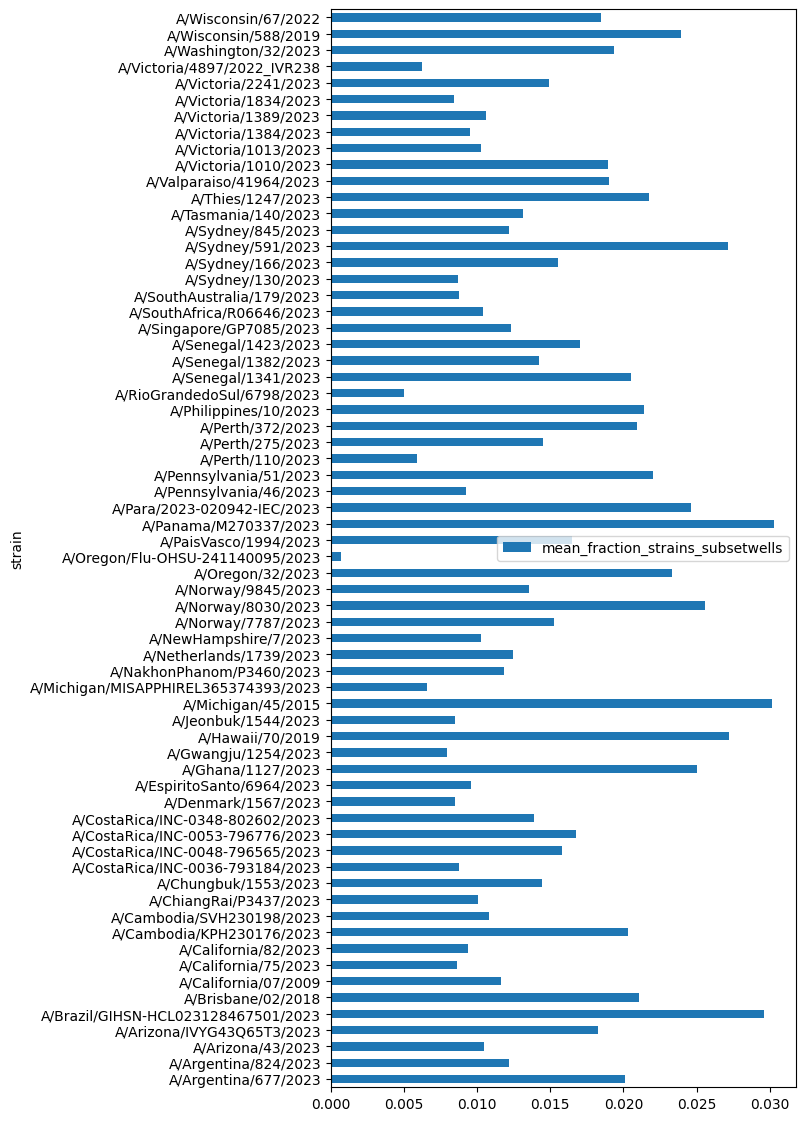

In [77]:
tidy = mean_single_well[['strain', 'mean_fraction_strains_subsetwells', 'mean_ratio_to_add']].drop_duplicates()
(mean_single_well
                 [['strain', 'mean_fraction_strains_subsetwells']]
                 .drop_duplicates()
                 .plot.barh(x="strain", y="mean_fraction_strains_subsetwells", figsize = (6,14), log=False)
)

In [78]:
tidy['vol_to_add'] = tidy['mean_ratio_to_add'].apply(lambda x: x * 70).to_list()

In [79]:
tidy

,strain,mean_fraction_strains_subsetwells,mean_ratio_to_add,vol_to_add
0,A/Argentina/677/2023,0.020088,0.743006,52.010408
3,A/Argentina/824/2023,0.012144,1.228996,86.029717
6,A/Arizona/43/2023,0.010460,1.426867,99.880703
9,A/Arizona/IVYG43Q65T3/2023,0.018248,0.817898,57.252868
12,A/Brazil/GIHSN-HCL023128467501/2023,0.029628,0.503762,35.263342
...,...,...,...,...
182,A/Victoria/2241/2023,0.014926,0.999983,69.998827
185,A/Victoria/4897/2022_IVR238,0.006224,2.398000,167.860000
188,A/Washington/32/2023,0.019332,0.772062,54.044319
191,A/Wisconsin/588/2019,0.023930,0.623702,43.659168


<Axes: ylabel='strain'>

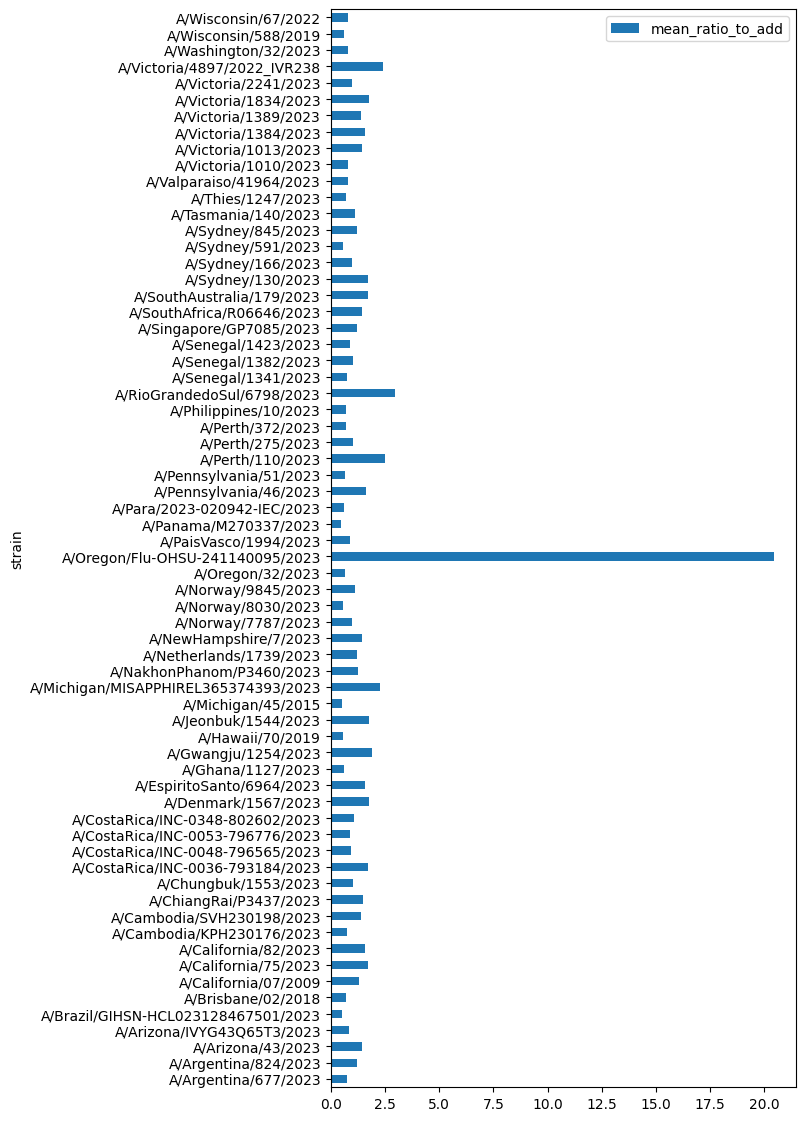

In [80]:
tidy = mean_single_well[['strain', 'mean_fraction_strains_subsetwells', 'mean_ratio_to_add']].drop_duplicates()
tidy.plot.barh(x="strain", y="mean_ratio_to_add", figsize = (6,14))

In [81]:
strains_to_add = ['A/Oregon/Flu-OHSU-241140095/2023','A/Victoria/4897/2022_IVR238']

In [82]:
tidy['strainstoadd'] = np.where(tidy['strain'].isin(strains_to_add),"yes","no")

In [89]:
tidy_strainspooled = tidy.loc[tidy['strainstoadd'] == "no"]

In [90]:
tidy_strainstoadd = tidy.loc[tidy['strainstoadd'] == "yes"]

In [91]:
tidy.to_csv("../results/miscellaneous_plates/test_volumestoadd.csv")